In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from pandas import DataFrame
from datetime import datetime
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D ,AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
# from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
#from tensorflow.keras.optimizers import Adam
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# input file path
datasetdir = "D://indivdual_models//Dataset//2022_EC11K_single_drug"
resultdir = "D://indivdual_models//Result//Model_generation//2022_EC11K_single_drug"

C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorf

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6034255917567930369
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8267490918
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11548212753272940036
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [2]:
drug_list = ["AEW541","Nilotinib","17-AAG","PHA-665752","Lapatinib","Nutlin-3"
            ,"AZD0530","PF2341066","L-685458","ZD-6474","Panobinostat","Sorafenib"
            ,"Irinotecan","Topotecan","LBW242","PD-0325901","PD-0332991","Paclitaxel"
            ,"PLX4720","RAF265","TAE684","TKI258","Erlotinib","AZD6244"]

In [3]:
# hyperparameters of CNN
num_classes = 1
learning_rate = 0.0002
training_epochs = 40
batch_size = 50
# img_rows, img_cols = 154, 154


In [4]:
#reset Keras Session for GPU memory refreshing
def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

Starttime: 20221007
AEW541_//n
train_X shape: (392, 18988, 1)
392 train samples
98 test samples
StartTime : 2022-10-07 15:22:46.112205

EndTime : 2022-10-07 15:22:48.360257
StartTime : 2022-10-07 15:22:48.360257

Train on 392 samples, validate on 98 samples
Epoch 1/40
392/392 [==============================] - 8s 19ms/step - loss: 4.6762 - mse: 4.6762 - mae: 1.9416 - val_loss: 3.3934 - val_mse: 3.3934 - val_mae: 1.7688
Epoch 2/40
392/392 [==============================] - 1s 1ms/step - loss: 3.9919 - mse: 3.9919 - mae: 1.7803 - val_loss: 3.3263 - val_mse: 3.3263 - val_mae: 1.7500
Epoch 3/40
392/392 [==============================] - 1s 1ms/step - loss: 3.4724 - mse: 3.4724 - mae: 1.6595 - val_loss: 3.2419 - val_mse: 3.2419 - val_mae: 1.7260
Epoch 4/40
392/392 [==============================] - 1s 1ms/step - loss: 2.8096 - mse: 2.8096 - mae: 1.4955 - val_loss: 3.2515 - val_mse: 3.2515 - val_mae: 1.7289
Epoch 5/40
392/392 [==============================] - 1s 2ms/step - loss: 2.5140 - ms

326/326 [==============================] - 1s 2ms/step - loss: 3.2200 - mse: 3.2200 - mae: 1.6450 - val_loss: 3.8432 - val_mse: 3.8432 - val_mae: 1.9282
Epoch 5/40
326/326 [==============================] - 1s 2ms/step - loss: 2.8839 - mse: 2.8839 - mae: 1.5339 - val_loss: 3.7077 - val_mse: 3.7077 - val_mae: 1.8937
Epoch 6/40
326/326 [==============================] - 1s 2ms/step - loss: 2.4844 - mse: 2.4844 - mae: 1.4050 - val_loss: 3.5991 - val_mse: 3.5991 - val_mae: 1.8657
Epoch 7/40
326/326 [==============================] - 0s 2ms/step - loss: 2.2782 - mse: 2.2782 - mae: 1.3436 - val_loss: 3.2737 - val_mse: 3.2737 - val_mae: 1.7806
Epoch 8/40
326/326 [==============================] - 0s 2ms/step - loss: 2.0846 - mse: 2.0846 - mae: 1.2871 - val_loss: 2.8887 - val_mse: 2.8887 - val_mae: 1.6738
Epoch 9/40
326/326 [==============================] - 0s 1ms/step - loss: 1.7895 - mse: 1.7895 - mae: 1.1554 - val_loss: 2.6065 - val_mse: 2.6065 - val_mae: 1.5902
Epoch 10/40
326/326 [======

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025B7BC1CC18>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


EndTime : 2022-10-07 15:24:29.796201
StartTime : 2022-10-07 15:24:29.796201
Train on 392 samples, validate on 98 samples
Epoch 1/40
392/392 [==============================] - 6s 15ms/step - loss: 5.1569 - mse: 5.1569 - mae: 1.8999 - val_loss: 4.3318 - val_mse: 4.3318 - val_mae: 1.7494
Epoch 2/40
392/392 [==============================] - 1s 1ms/step - loss: 3.5159 - mse: 3.5159 - mae: 1.5657 - val_loss: 4.1157 - val_mse: 4.1157 - val_mae: 1.6952
Epoch 3/40
392/392 [==============================] - 1s 1ms/step - loss: 2.6245 - mse: 2.6245 - mae: 1.3570 - val_loss: 3.9140 - val_mse: 3.9140 - val_mae: 1.6418
Epoch 4/40
392/392 [==============================] - 1s 1ms/step - loss: 2.0672 - mse: 2.0672 - mae: 1.2076 - val_loss: 3.6828 - val_mse: 3.6828 - val_mae: 1.5803
Epoch 5/40
392/392 [==============================] - 1s 1ms/step - loss: 1.6318 - mse: 1.6318 - mae: 1.0854 - val_loss: 3.4552 - val_mse: 3.4552 - val_mae: 1.5212
Epoch 6/40
392/392 [==============================] - 1s 1

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025CB5F01DA0>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 392 samples, validate on 98 samples
Epoch 1/40
392/392 [==============================] - 10s 27ms/step - loss: 4.7900 - mse: 4.7900 - mae: 2.0185 - val_loss: 4.1661 - val_mse: 4.1661 - val_mae: 2.0185
Epoch 2/40
392/392 [==============================] - 1s 2ms/step - loss: 4.6033 - mse: 4.6033 - mae: 1.9447 - val_loss: 4.0947 - val_mse: 4.0947 - val_mae: 2.0003
Epoch 3/40
392/392 [==============================] - 1s 2ms/step - loss: 3.9463 - mse: 3.9463 - mae: 1.8237 - val_loss: 4.0042 - val_mse: 4.0042 - val_mae: 1.9766
Epoch 4/40
392/392 [==============================] - 1s 2ms/step - loss: 3.2532 - mse: 3.2532 - mae: 1.6590 - val_loss: 3.8463 - val_mse: 3.8463 - val_mae: 1.9353
Epoch 5/40
392/392 [==============================] - 1s 2ms/step - loss: 3.0028 - mse: 3.0028 - mae: 1.5757 - val_loss: 3.6625 - val_mse: 3.6625 - val_mae: 1.8860
Epoch 6/40
392/392 [==============================] - 1s 2ms/step - loss: 2.7626 - mse: 2.7626 - mae: 1.5004 - val_loss: 3.5050 - val

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025CC6FD9518>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


EndTime : 2022-10-07 15:26:50.907641
StartTime : 2022-10-07 15:26:50.907641
Train on 393 samples, validate on 98 samples
Epoch 1/40
393/393 [==============================] - 11s 28ms/step - loss: 5.9851 - mse: 5.9851 - mae: 2.2604 - val_loss: 3.4583 - val_mse: 3.4583 - val_mae: 1.7788
Epoch 2/40
393/393 [==============================] - 1s 2ms/step - loss: 5.0239 - mse: 5.0239 - mae: 2.0832 - val_loss: 3.4477 - val_mse: 3.4477 - val_mae: 1.7759
Epoch 3/40
393/393 [==============================] - 1s 2ms/step - loss: 4.3902 - mse: 4.3902 - mae: 1.9426 - val_loss: 3.4468 - val_mse: 3.4468 - val_mae: 1.7761
Epoch 4/40
393/393 [==============================] - 1s 2ms/step - loss: 4.0569 - mse: 4.0569 - mae: 1.8590 - val_loss: 3.3983 - val_mse: 3.3983 - val_mae: 1.7635
Epoch 5/40
393/393 [==============================] - 1s 2ms/step - loss: 3.3483 - mse: 3.3483 - mae: 1.7018 - val_loss: 3.3025 - val_mse: 3.3025 - val_mae: 1.7384
Epoch 6/40
393/393 [==============================] - 1s 

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025CCBC60BA8>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


Train on 393 samples, validate on 98 samples
Epoch 1/40
393/393 [==============================] - 13s 32ms/step - loss: 5.0603 - mse: 5.0603 - mae: 2.0188 - val_loss: 4.3547 - val_mse: 4.3547 - val_mae: 2.0617
Epoch 2/40
393/393 [==============================] - 1s 2ms/step - loss: 4.3965 - mse: 4.3965 - mae: 1.8813 - val_loss: 4.1081 - val_mse: 4.1081 - val_mae: 1.9992
Epoch 3/40
393/393 [==============================] - 1s 2ms/step - loss: 3.8678 - mse: 3.8678 - mae: 1.7725 - val_loss: 3.7746 - val_mse: 3.7746 - val_mae: 1.9114
Epoch 4/40
393/393 [==============================] - 1s 2ms/step - loss: 3.3412 - mse: 3.3412 - mae: 1.6480 - val_loss: 3.4103 - val_mse: 3.4103 - val_mae: 1.8095
Epoch 5/40
393/393 [==============================] - 1s 2ms/step - loss: 2.8642 - mse: 2.8642 - mae: 1.5092 - val_loss: 3.1295 - val_mse: 3.1295 - val_mae: 1.7268
Epoch 6/40
393/393 [==============================] - 1s 2ms/step - loss: 2.5572 - mse: 2.5572 - mae: 1.4594 - val_loss: 2.8414 - val

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025CBFE31DA0>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 393 samples, validate on 98 samples
Epoch 1/40
393/393 [==============================] - 12s 29ms/step - loss: 3.6022 - mse: 3.6022 - mae: 1.6749 - val_loss: 3.5099 - val_mse: 3.5099 - val_mae: 1.7955
Epoch 2/40
393/393 [==============================] - 1s 2ms/step - loss: 3.0472 - mse: 3.0472 - mae: 1.5133 - val_loss: 3.3911 - val_mse: 3.3911 - val_mae: 1.7644
Epoch 3/40
393/393 [==============================] - 1s 2ms/step - loss: 2.2712 - mse: 2.2712 - mae: 1.3273 - val_loss: 3.2969 - val_mse: 3.2969 - val_mae: 1.7391
Epoch 4/40
393/393 [==============================] - 1s 2ms/step - loss: 2.0375 - mse: 2.0375 - mae: 1.2126 - val_loss: 3.1096 - val_mse: 3.1096 - val_mae: 1.6887
Epoch 5/40
393/393 [==============================] - 1s 2ms/step - loss: 1.6431 - mse: 1.6431 - mae: 1.1173 - val_loss: 2.9396 - val_mse: 2.9396 - val_mae: 1.6420
Epoch 6/40
393/393 [==============================] - 1s 2ms/step - loss: 1.3966 - mse: 1.3966 - mae: 1.0130 - val_loss: 2.7017 - val

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025B76B982E8>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


EndTime : 2022-10-07 15:31:22.106379
StartTime : 2022-10-07 15:31:22.106379
Train on 393 samples, validate on 98 samples
Epoch 1/40
393/393 [==============================] - 13s 32ms/step - loss: 6.3425 - mse: 6.3425 - mae: 2.3341 - val_loss: 3.6777 - val_mse: 3.6777 - val_mae: 1.8506
Epoch 2/40
393/393 [==============================] - 1s 2ms/step - loss: 5.2956 - mse: 5.2956 - mae: 2.1592 - val_loss: 3.6422 - val_mse: 3.6422 - val_mae: 1.8417
Epoch 3/40
393/393 [==============================] - 1s 2ms/step - loss: 4.7094 - mse: 4.7094 - mae: 2.0226 - val_loss: 3.5405 - val_mse: 3.5405 - val_mae: 1.8160
Epoch 4/40
393/393 [==============================] - 1s 2ms/step - loss: 4.2904 - mse: 4.2904 - mae: 1.9055 - val_loss: 3.2844 - val_mse: 3.2844 - val_mae: 1.7495
Epoch 5/40
393/393 [==============================] - 1s 2ms/step - loss: 3.4896 - mse: 3.4896 - mae: 1.7411 - val_loss: 3.0135 - val_mse: 3.0135 - val_mae: 1.6754
Epoch 6/40
393/393 [==============================] - 1s 

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025C1DF644A8>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


Train on 383 samples, validate on 95 samples
Epoch 1/40
383/383 [==============================] - 13s 33ms/step - loss: 4.9882 - mse: 4.9882 - mae: 2.0316 - val_loss: 3.7636 - val_mse: 3.7636 - val_mae: 1.9007
Epoch 2/40
383/383 [==============================] - 1s 2ms/step - loss: 4.3152 - mse: 4.3152 - mae: 1.8611 - val_loss: 3.3239 - val_mse: 3.3239 - val_mae: 1.7904
Epoch 3/40
383/383 [==============================] - 1s 2ms/step - loss: 3.5465 - mse: 3.5465 - mae: 1.7089 - val_loss: 2.9176 - val_mse: 2.9176 - val_mae: 1.6821
Epoch 4/40
383/383 [==============================] - 1s 2ms/step - loss: 3.2404 - mse: 3.2404 - mae: 1.6081 - val_loss: 2.6384 - val_mse: 2.6384 - val_mae: 1.6021
Epoch 5/40
383/383 [==============================] - 1s 2ms/step - loss: 2.8252 - mse: 2.8252 - mae: 1.5178 - val_loss: 2.3548 - val_mse: 2.3548 - val_mae: 1.5150
Epoch 6/40
383/383 [==============================] - 1s 2ms/step - loss: 2.4664 - mse: 2.4664 - mae: 1.4064 - val_loss: 2.0648 - val

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025CC061BBE0>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 387 samples, validate on 96 samples
Epoch 1/40
387/387 [==============================] - 6s 16ms/step - loss: 4.4718 - mse: 4.4718 - mae: 1.8957 - val_loss: 3.2861 - val_mse: 3.2861 - val_mae: 1.7074
Epoch 2/40
387/387 [==============================] - 1s 2ms/step - loss: 3.6260 - mse: 3.6260 - mae: 1.7034 - val_loss: 3.2084 - val_mse: 3.2084 - val_mae: 1.6854
Epoch 3/40
387/387 [==============================] - 1s 2ms/step - loss: 3.0368 - mse: 3.0368 - mae: 1.5448 - val_loss: 3.1566 - val_mse: 3.1566 - val_mae: 1.6704
Epoch 4/40
387/387 [==============================] - 1s 2ms/step - loss: 2.7380 - mse: 2.7380 - mae: 1.4583 - val_loss: 3.1651 - val_mse: 3.1651 - val_mae: 1.6727
Epoch 5/40
387/387 [==============================] - 1s 1ms/step - loss: 2.4626 - mse: 2.4626 - mae: 1.3619 - val_loss: 3.1878 - val_mse: 3.1878 - val_mae: 1.6792
Epoch 6/40
387/387 [==============================] - 1s 2ms/step - loss: 1.9655 - mse: 1.9655 - mae: 1.2364 - val_loss: 3.1095 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025CC3F8E278>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


EndTime : 2022-10-07 15:35:12.494118
StartTime : 2022-10-07 15:35:12.494118
Train on 390 samples, validate on 97 samples
Epoch 1/40
390/390 [==============================] - 6s 16ms/step - loss: 5.0835 - mse: 5.0835 - mae: 1.9596 - val_loss: 8.7287 - val_mse: 8.7287 - val_mae: 2.8288
Epoch 2/40
390/390 [==============================] - 1s 2ms/step - loss: 4.3421 - mse: 4.3421 - mae: 1.8536 - val_loss: 8.9222 - val_mse: 8.9222 - val_mae: 2.8619
Epoch 3/40
390/390 [==============================] - 1s 2ms/step - loss: 3.5908 - mse: 3.5908 - mae: 1.7140 - val_loss: 8.8281 - val_mse: 8.8281 - val_mae: 2.8449
Epoch 4/40
390/390 [==============================] - 1s 2ms/step - loss: 3.0066 - mse: 3.0066 - mae: 1.5743 - val_loss: 8.5867 - val_mse: 8.5867 - val_mae: 2.8026
Epoch 5/40
390/390 [==============================] - 1s 1ms/step - loss: 2.6455 - mse: 2.6455 - mae: 1.4658 - val_loss: 8.0860 - val_mse: 8.0860 - val_mae: 2.7119
Epoch 6/40
390/390 [==============================] - 1s 2

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025BF7BA4550>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


Train on 392 samples, validate on 98 samples
Epoch 1/40
392/392 [==============================] - 6s 16ms/step - loss: 5.9417 - mse: 5.9417 - mae: 2.2304 - val_loss: 3.8678 - val_mse: 3.8678 - val_mae: 1.9455
Epoch 2/40
392/392 [==============================] - 1s 2ms/step - loss: 5.3283 - mse: 5.3283 - mae: 2.0864 - val_loss: 3.6555 - val_mse: 3.6555 - val_mae: 1.8897
Epoch 3/40
392/392 [==============================] - 1s 1ms/step - loss: 4.6743 - mse: 4.6743 - mae: 1.9793 - val_loss: 3.4252 - val_mse: 3.4252 - val_mae: 1.8267
Epoch 4/40
392/392 [==============================] - 1s 1ms/step - loss: 4.2393 - mse: 4.2393 - mae: 1.8873 - val_loss: 3.1656 - val_mse: 3.1656 - val_mae: 1.7522
Epoch 5/40
392/392 [==============================] - 1s 1ms/step - loss: 3.6674 - mse: 3.6674 - mae: 1.7390 - val_loss: 2.9810 - val_mse: 2.9810 - val_mae: 1.6968
Epoch 6/40
392/392 [==============================] - 1s 1ms/step - loss: 3.3086 - mse: 3.3086 - mae: 1.6526 - val_loss: 2.8207 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025CC1BC3390>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 245 samples, validate on 61 samples
Epoch 1/40
245/245 [==============================] - 6s 26ms/step - loss: 2.6427 - mse: 2.6427 - mae: 1.2870 - val_loss: 2.8390 - val_mse: 2.8390 - val_mae: 1.4363
Epoch 2/40
245/245 [==============================] - 0s 2ms/step - loss: 1.6632 - mse: 1.6632 - mae: 1.0334 - val_loss: 2.7802 - val_mse: 2.7802 - val_mae: 1.4214
Epoch 3/40
245/245 [==============================] - 0s 1ms/step - loss: 1.1134 - mse: 1.1134 - mae: 0.8210 - val_loss: 2.7695 - val_mse: 2.7695 - val_mae: 1.4187
Epoch 4/40
245/245 [==============================] - 0s 2ms/step - loss: 0.7757 - mse: 0.7757 - mae: 0.6884 - val_loss: 2.7458 - val_mse: 2.7458 - val_mae: 1.4113
Epoch 5/40
245/245 [==============================] - 0s 2ms/step - loss: 0.7604 - mse: 0.7604 - mae: 0.6693 - val_loss: 2.7091 - val_mse: 2.7091 - val_mae: 1.4010
Epoch 6/40
245/245 [==============================] - 0s 2ms/step - loss: 0.5884 - mse: 0.5884 - mae: 0.5703 - val_loss: 2.6427 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025B75F59EF0>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


EndTime : 2022-10-07 15:37:45.999783
StartTime : 2022-10-07 15:37:45.999783
Train on 393 samples, validate on 98 samples
Epoch 1/40
393/393 [==============================] - 6s 16ms/step - loss: 4.0688 - mse: 4.0688 - mae: 1.6647 - val_loss: 2.6756 - val_mse: 2.6756 - val_mae: 1.3748
Epoch 2/40
393/393 [==============================] - 1s 2ms/step - loss: 2.2760 - mse: 2.2760 - mae: 1.2125 - val_loss: 2.6844 - val_mse: 2.6844 - val_mae: 1.3784
Epoch 3/40
393/393 [==============================] - 1s 2ms/step - loss: 1.6085 - mse: 1.6085 - mae: 1.0095 - val_loss: 2.7005 - val_mse: 2.7005 - val_mae: 1.3828
Epoch 4/40
393/393 [==============================] - 1s 2ms/step - loss: 1.2742 - mse: 1.2742 - mae: 0.9209 - val_loss: 2.7270 - val_mse: 2.7270 - val_mae: 1.3891
Epoch 5/40
393/393 [==============================] - 1s 2ms/step - loss: 0.9247 - mse: 0.9247 - mae: 0.7411 - val_loss: 2.7460 - val_mse: 2.7460 - val_mae: 1.3933
Epoch 6/40
393/393 [==============================] - 1s 2

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025CC77E70B8>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 392 samples, validate on 98 samples
Epoch 1/40
392/392 [==============================] - 6s 16ms/step - loss: 4.1849 - mse: 4.1849 - mae: 1.8652 - val_loss: 3.9614 - val_mse: 3.9614 - val_mae: 1.9790
Epoch 2/40
392/392 [==============================] - 1s 2ms/step - loss: 3.3698 - mse: 3.3698 - mae: 1.6698 - val_loss: 3.7422 - val_mse: 3.7422 - val_mae: 1.9239
Epoch 3/40
392/392 [==============================] - 1s 2ms/step - loss: 2.7013 - mse: 2.7013 - mae: 1.4796 - val_loss: 3.5746 - val_mse: 3.5746 - val_mae: 1.8805
Epoch 4/40
392/392 [==============================] - 1s 2ms/step - loss: 2.2898 - mse: 2.2898 - mae: 1.3387 - val_loss: 3.3130 - val_mse: 3.3130 - val_mae: 1.8106
Epoch 5/40
392/392 [==============================] - 1s 2ms/step - loss: 1.9419 - mse: 1.9419 - mae: 1.2416 - val_loss: 3.0301 - val_mse: 3.0301 - val_mae: 1.7318
Epoch 6/40
392/392 [==============================] - 1s 2ms/step - loss: 1.8047 - mse: 1.8047 - mae: 1.1580 - val_loss: 2.8000 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025CC1074CF8>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 393 samples, validate on 98 samples
Epoch 1/40
393/393 [==============================] - 6s 16ms/step - loss: 7.2734 - mse: 7.2734 - mae: 2.4014 - val_loss: 4.7797 - val_mse: 4.7797 - val_mae: 1.9733
Epoch 2/40
393/393 [==============================] - 1s 2ms/step - loss: 4.0231 - mse: 4.0231 - mae: 1.7543 - val_loss: 4.8492 - val_mse: 4.8492 - val_mae: 2.0006
Epoch 3/40
393/393 [==============================] - 1s 1ms/step - loss: 2.6365 - mse: 2.6365 - mae: 1.3974 - val_loss: 4.9513 - val_mse: 4.9513 - val_mae: 2.0351
Epoch 4/40
393/393 [==============================] - 1s 1ms/step - loss: 1.7716 - mse: 1.7716 - mae: 1.1139 - val_loss: 5.0197 - val_mse: 5.0197 - val_mae: 2.0555
Epoch 5/40
393/393 [==============================] - 1s 1ms/step - loss: 1.4964 - mse: 1.4964 - mae: 0.9808 - val_loss: 5.0368 - val_mse: 5.0368 - val_mae: 2.0605
Epoch 6/40
393/393 [==============================] - 1s 1ms/step - loss: 1.4042 - mse: 1.4042 - mae: 0.9390 - val_loss: 4.9832 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025CB14E9DA0>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


EndTime : 2022-10-07 15:40:31.042486
StartTime : 2022-10-07 15:40:31.042486
Train on 337 samples, validate on 84 samples
Epoch 1/40
337/337 [==============================] - 6s 19ms/step - loss: 6.6407 - mse: 6.6407 - mae: 2.4259 - val_loss: 3.9691 - val_mse: 3.9691 - val_mae: 1.9464
Epoch 2/40
337/337 [==============================] - 1s 2ms/step - loss: 5.9796 - mse: 5.9796 - mae: 2.3209 - val_loss: 3.9206 - val_mse: 3.9206 - val_mae: 1.9347
Epoch 3/40
337/337 [==============================] - 1s 2ms/step - loss: 5.4942 - mse: 5.4942 - mae: 2.2301 - val_loss: 3.8286 - val_mse: 3.8286 - val_mae: 1.9125
Epoch 4/40
337/337 [==============================] - 1s 2ms/step - loss: 4.9571 - mse: 4.9571 - mae: 2.1390 - val_loss: 3.7339 - val_mse: 3.7339 - val_mae: 1.8892
Epoch 5/40
337/337 [==============================] - 1s 2ms/step - loss: 4.4765 - mse: 4.4765 - mae: 2.0290 - val_loss: 3.6262 - val_mse: 3.6262 - val_mae: 1.8625
Epoch 6/40
337/337 [==============================] - 1s 2

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025CB46A77B8>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 392 samples, validate on 98 samples
Epoch 1/40
392/392 [==============================] - 6s 16ms/step - loss: 19.3718 - mse: 19.3718 - mae: 4.1720 - val_loss: 21.7011 - val_mse: 21.7011 - val_mae: 4.4474
Epoch 2/40
392/392 [==============================] - ETA: 0s - loss: 17.2452 - mse: 17.2452 - mae: 3.961 - 1s 2ms/step - loss: 17.3184 - mse: 17.3184 - mae: 3.9672 - val_loss: 21.7077 - val_mse: 21.7077 - val_mae: 4.4488
Epoch 3/40
392/392 [==============================] - 1s 2ms/step - loss: 15.5729 - mse: 15.5729 - mae: 3.7281 - val_loss: 21.7056 - val_mse: 21.7056 - val_mae: 4.4485
Epoch 4/40
392/392 [==============================] - 1s 2ms/step - loss: 14.0695 - mse: 14.0695 - mae: 3.5748 - val_loss: 21.5576 - val_mse: 21.5576 - val_mae: 4.4336
Epoch 5/40
392/392 [==============================] - 1s 2ms/step - loss: 12.7446 - mse: 12.7446 - mae: 3.4154 - val_loss: 21.2866 - val_mse: 21.2866 - val_mae: 4.4065
Epoch 6/40
392/392 [==============================] - 1s 2ms

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025CB5DDEFD0>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 387 samples, validate on 96 samples
Epoch 1/40
387/387 [==============================] - 7s 18ms/step - loss: 3.0127 - mse: 3.0127 - mae: 1.4983 - val_loss: 3.8334 - val_mse: 3.8334 - val_mae: 1.9304
Epoch 2/40
387/387 [==============================] - 1s 2ms/step - loss: 2.6353 - mse: 2.6353 - mae: 1.3702 - val_loss: 3.6934 - val_mse: 3.6934 - val_mae: 1.8957
Epoch 3/40
387/387 [==============================] - 1s 2ms/step - loss: 2.0049 - mse: 2.0049 - mae: 1.1625 - val_loss: 3.4907 - val_mse: 3.4907 - val_mae: 1.8444
Epoch 4/40
387/387 [==============================] - 1s 2ms/step - loss: 1.6414 - mse: 1.6414 - mae: 1.0614 - val_loss: 3.2677 - val_mse: 3.2677 - val_mae: 1.7861
Epoch 5/40
387/387 [==============================] - 1s 2ms/step - loss: 1.3257 - mse: 1.3257 - mae: 0.9619 - val_loss: 3.1027 - val_mse: 3.1027 - val_mae: 1.7414
Epoch 6/40
387/387 [==============================] - 1s 2ms/step - loss: 1.1033 - mse: 1.1033 - mae: 0.8572 - val_loss: 2.9513 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025CC40767B8>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


Train on 358 samples, validate on 89 samples
Epoch 1/40
358/358 [==============================] - 6s 18ms/step - loss: 2.3131 - mse: 2.3131 - mae: 1.2678 - val_loss: 2.0495 - val_mse: 2.0495 - val_mae: 1.2631
Epoch 2/40
358/358 [==============================] - 1s 2ms/step - loss: 1.3008 - mse: 1.3008 - mae: 0.9120 - val_loss: 1.9592 - val_mse: 1.9592 - val_mae: 1.2380
Epoch 3/40
358/358 [==============================] - 1s 2ms/step - loss: 1.0216 - mse: 1.0216 - mae: 0.7835 - val_loss: 1.9627 - val_mse: 1.9627 - val_mae: 1.2383
Epoch 4/40
358/358 [==============================] - 1s 2ms/step - loss: 0.9014 - mse: 0.9014 - mae: 0.7459 - val_loss: 2.0374 - val_mse: 2.0374 - val_mae: 1.2594
Epoch 5/40
358/358 [==============================] - 1s 2ms/step - loss: 0.6816 - mse: 0.6816 - mae: 0.6356 - val_loss: 2.0505 - val_mse: 2.0505 - val_mae: 1.2627
Epoch 6/40
358/358 [==============================] - 1s 2ms/step - loss: 0.6550 - mse: 0.6550 - mae: 0.6224 - val_loss: 1.9645 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025CB53A45C0>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 393 samples, validate on 98 samples
Epoch 1/40
393/393 [==============================] - 6s 16ms/step - loss: 2.5004 - mse: 2.5004 - mae: 1.2755 - val_loss: 2.8852 - val_mse: 2.8852 - val_mae: 1.5242
Epoch 2/40
393/393 [==============================] - 1s 1ms/step - loss: 1.6205 - mse: 1.6205 - mae: 1.0220 - val_loss: 2.9660 - val_mse: 2.9660 - val_mae: 1.5490
Epoch 3/40
393/393 [==============================] - 1s 2ms/step - loss: 1.1895 - mse: 1.1895 - mae: 0.8791 - val_loss: 2.9218 - val_mse: 2.9218 - val_mae: 1.5354
Epoch 4/40
393/393 [==============================] - 1s 2ms/step - loss: 1.0439 - mse: 1.0439 - mae: 0.7859 - val_loss: 2.7560 - val_mse: 2.7560 - val_mae: 1.4859
Epoch 5/40
393/393 [==============================] - 1s 2ms/step - loss: 0.9084 - mse: 0.9084 - mae: 0.7259 - val_loss: 2.5773 - val_mse: 2.5773 - val_mae: 1.4287
Epoch 6/40
393/393 [==============================] - 1s 2ms/step - loss: 0.6788 - mse: 0.6788 - mae: 0.6450 - val_loss: 2.4019 - val_

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025B5569A6A0>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


Train on 393 samples, validate on 98 samples
Epoch 1/40
393/393 [==============================] - 6s 16ms/step - loss: 12.0674 - mse: 12.0674 - mae: 3.2971 - val_loss: 3.2147 - val_mse: 3.2147 - val_mae: 1.6885
Epoch 2/40
393/393 [==============================] - 1s 2ms/step - loss: 10.8096 - mse: 10.8096 - mae: 3.1204 - val_loss: 3.3636 - val_mse: 3.3636 - val_mae: 1.7277
Epoch 3/40
393/393 [==============================] - 1s 2ms/step - loss: 9.6007 - mse: 9.6007 - mae: 2.9621 - val_loss: 3.5189 - val_mse: 3.5189 - val_mae: 1.7678
Epoch 4/40
393/393 [==============================] - 1s 2ms/step - loss: 9.3005 - mse: 9.3005 - mae: 2.9122 - val_loss: 3.6244 - val_mse: 3.6244 - val_mae: 1.7948
Epoch 5/40
393/393 [==============================] - 1s 2ms/step - loss: 8.2202 - mse: 8.2202 - mae: 2.7583 - val_loss: 3.6730 - val_mse: 3.6730 - val_mae: 1.8069
Epoch 6/40
393/393 [==============================] - 1s 2ms/step - loss: 7.5587 - mse: 7.5587 - mae: 2.6213 - val_loss: 3.7088 - 

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025CC533AC50>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


Train on 392 samples, validate on 98 samples
Epoch 1/40
392/392 [==============================] - 11s 29ms/step - loss: 5.9774 - mse: 5.9774 - mae: 2.2629 - val_loss: 3.8407 - val_mse: 3.8407 - val_mae: 1.9101
Epoch 2/40
392/392 [==============================] - 1s 2ms/step - loss: 5.1940 - mse: 5.1940 - mae: 2.1153 - val_loss: 3.8768 - val_mse: 3.8768 - val_mae: 1.9194
Epoch 3/40
392/392 [==============================] - 1s 2ms/step - loss: 4.4677 - mse: 4.4677 - mae: 1.9842 - val_loss: 3.9311 - val_mse: 3.9311 - val_mae: 1.9326
Epoch 4/40
392/392 [==============================] - 1s 2ms/step - loss: 3.9493 - mse: 3.9493 - mae: 1.8542 - val_loss: 3.9180 - val_mse: 3.9180 - val_mae: 1.9297
Epoch 5/40
392/392 [==============================] - 1s 2ms/step - loss: 3.3579 - mse: 3.3579 - mae: 1.7097 - val_loss: 3.8942 - val_mse: 3.8942 - val_mae: 1.9237
Epoch 6/40
392/392 [==============================] - 1s 2ms/step - loss: 3.0401 - mse: 3.0401 - mae: 1.6282 - val_loss: 3.8886 - val

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000025B6EAF1208>>
Traceback (most recent call last):
  File "C:\Users\BGM18\.conda\envs\ronny_keras\lib\site-packages\tensorflow\python\client\session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


Train on 392 samples, validate on 98 samples
Epoch 1/40
392/392 [==============================] - 10s 26ms/step - loss: 5.0955 - mse: 5.0955 - mae: 2.0406 - val_loss: 3.8800 - val_mse: 3.8800 - val_mae: 1.8848
Epoch 2/40
392/392 [==============================] - 1s 2ms/step - loss: 3.5231 - mse: 3.5231 - mae: 1.6335 - val_loss: 3.7208 - val_mse: 3.7208 - val_mae: 1.8440
Epoch 3/40
392/392 [==============================] - 1s 2ms/step - loss: 2.5318 - mse: 2.5318 - mae: 1.3748 - val_loss: 3.5208 - val_mse: 3.5208 - val_mae: 1.7896
Epoch 4/40
392/392 [==============================] - 1s 2ms/step - loss: 2.1463 - mse: 2.1463 - mae: 1.2496 - val_loss: 3.3218 - val_mse: 3.3218 - val_mae: 1.7324
Epoch 5/40
392/392 [==============================] - 1s 2ms/step - loss: 1.7610 - mse: 1.7610 - mae: 1.1117 - val_loss: 3.1483 - val_mse: 3.1483 - val_mae: 1.6807
Epoch 6/40
392/392 [==============================] - 1s 2ms/step - loss: 1.4784 - mse: 1.4784 - mae: 1.0051 - val_loss: 3.0094 - val

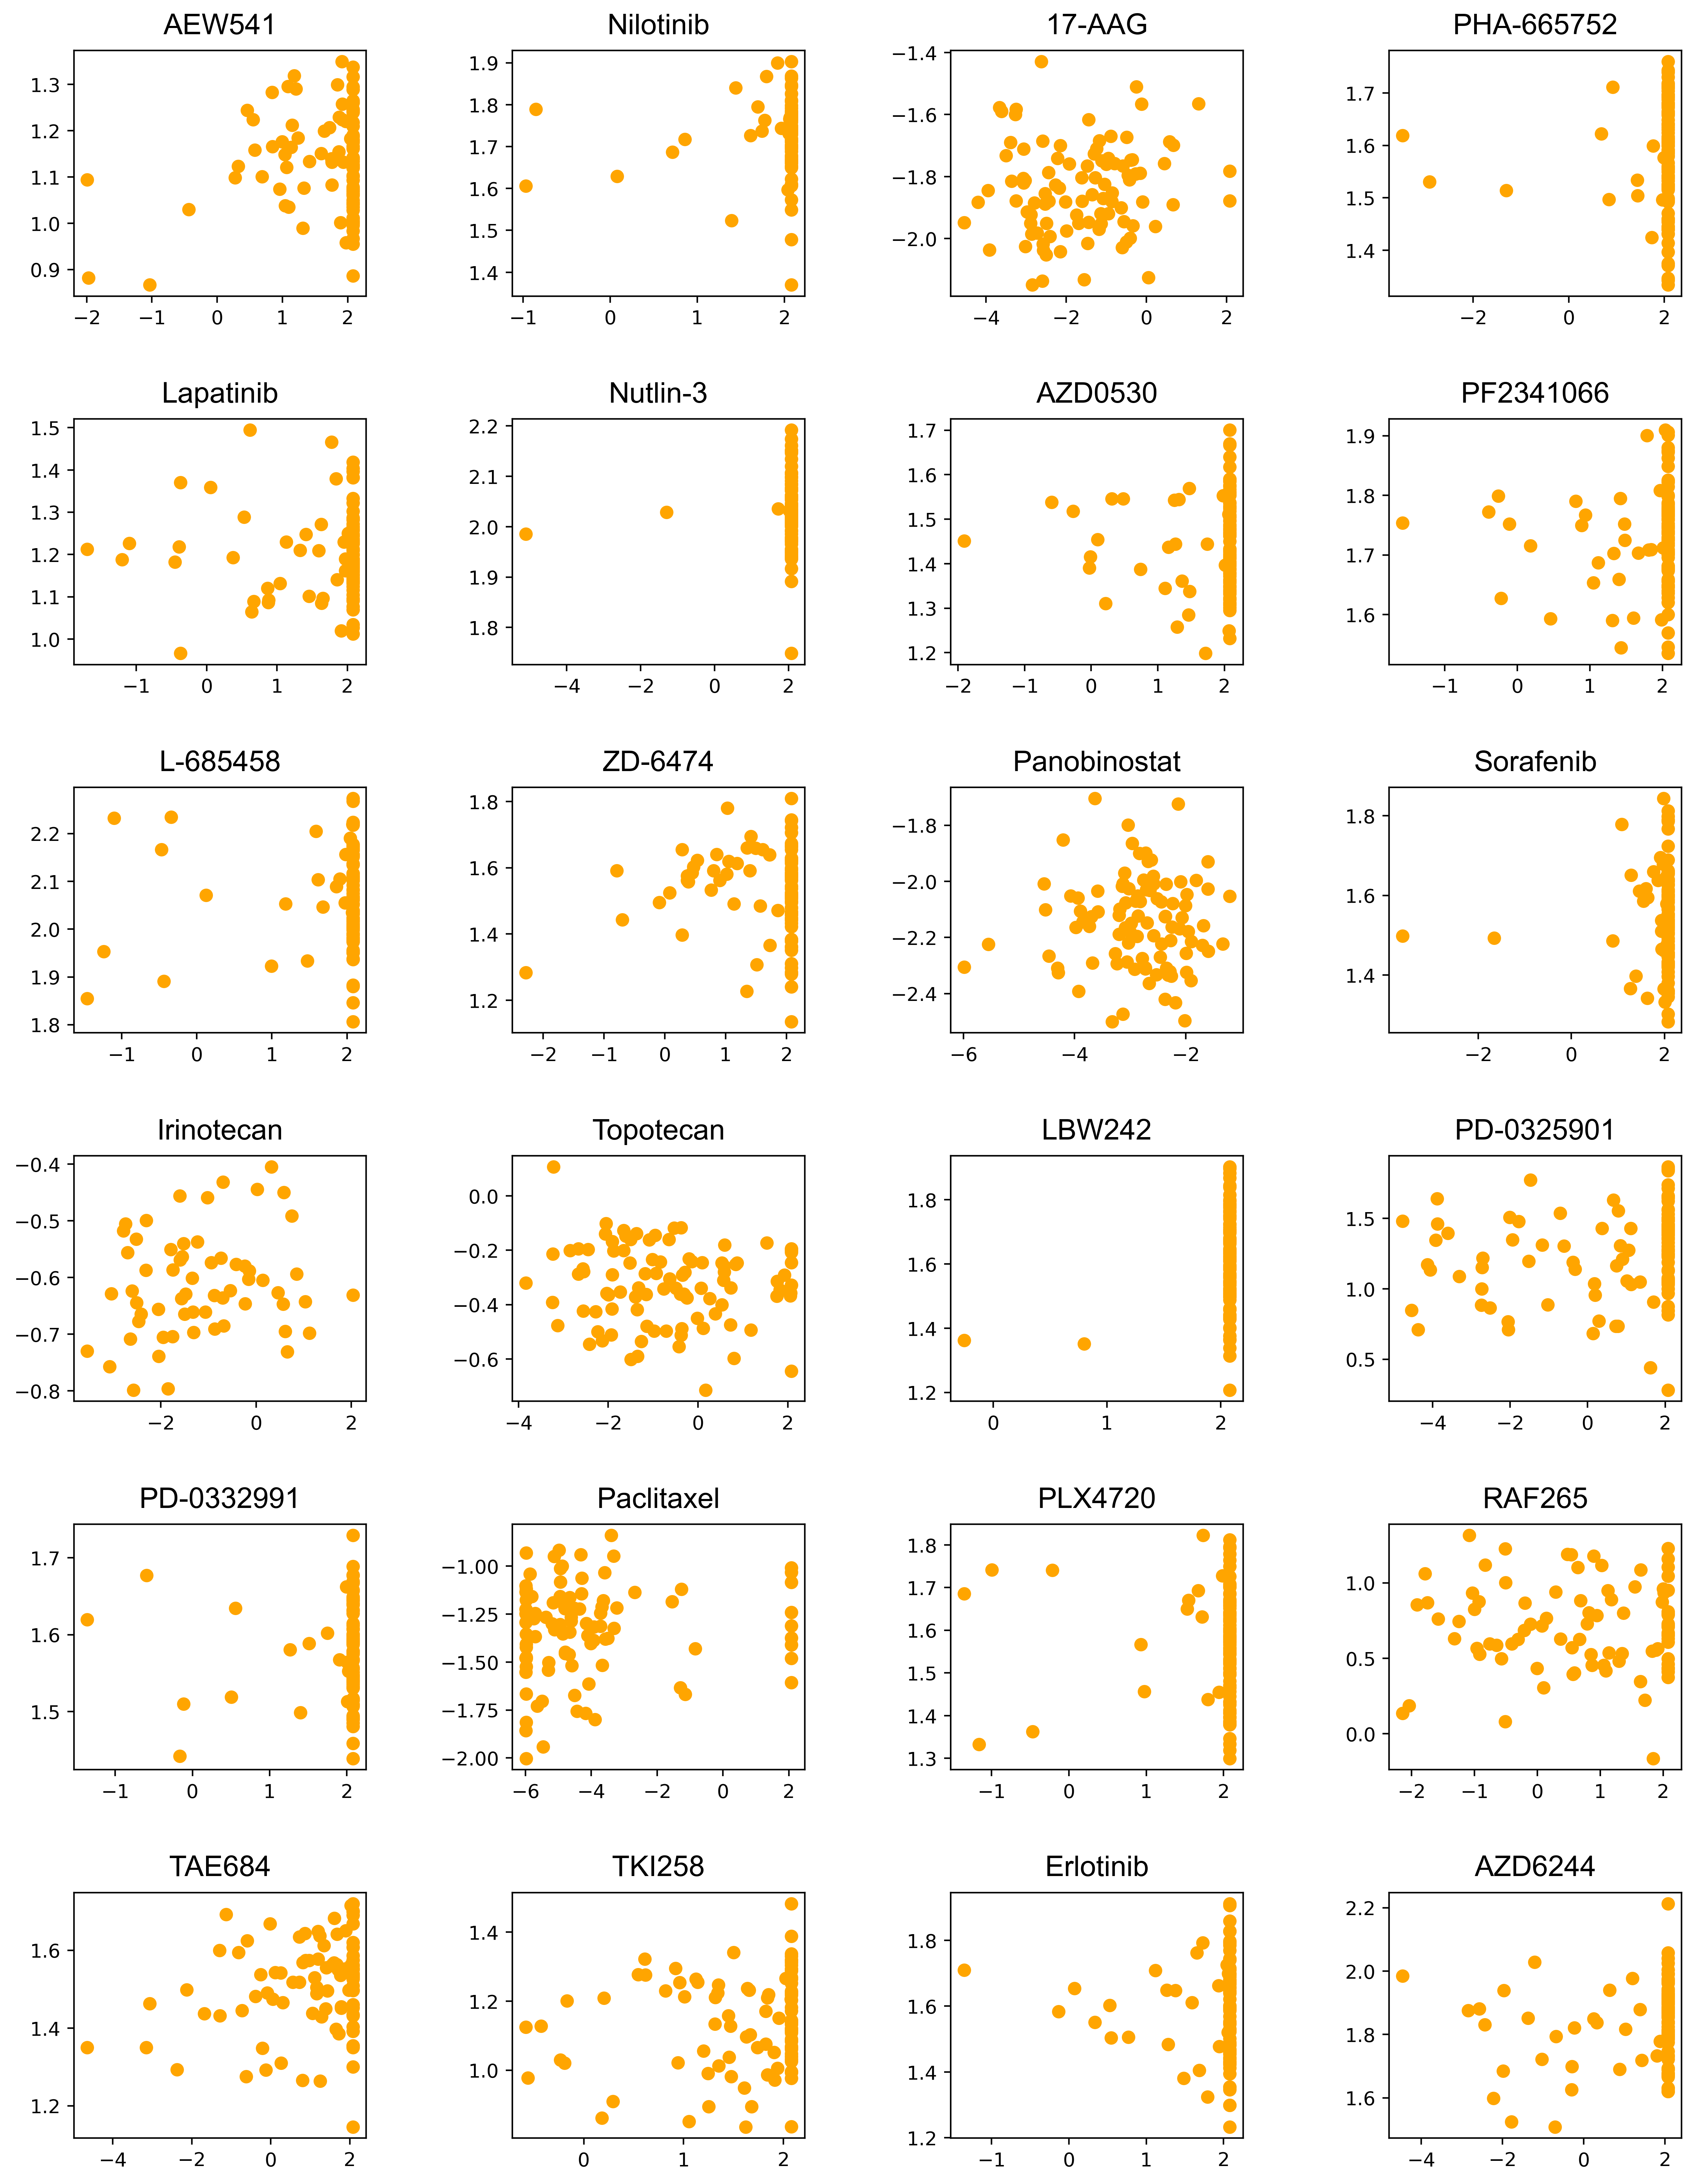

In [6]:
from datetime import datetime
now = datetime.now()
day = now.strftime("%Y%m%d")
print("Starttime: " + day)

rmselist = []
r2list = []

# drug_list = ["Topotecan"]
fig = plt.figure(figsize=(15,20),dpi=400)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
num = 1
for dname in drug_list:
    
    print('%s_//n' % dname)
    # read input file and index file for training and test set
    dataset = np.load(datasetdir + "//EC11K_%s.npz" % dname)
    ss0 = np.load(datasetdir + '//EC11K_%s_0_8_2.npz' % dname)

    # input and index file assign
    x = dataset['x']
    y = dataset['y']
    # y_linear = dataset['y_lnIC50']
    ss0_train = ss0['train']
    ss0_test = ss0['test']
    
    # z-normalization
    
    # training and test dataset assign
    train_X, train_y = x[ss0_train], y[ss0_train]
    test_X, test_y = x[ss0_test], y[ss0_test]
    
    from sklearn import preprocessing
    import pickle
    scaler = preprocessing.StandardScaler()
    train_X = scaler.fit_transform(train_X)
    pickle.dump(scaler, open(datasetdir + "//standardization_models//znorm_scaler_%s.pkl" % dname, 'wb'))
    test_X = scaler.transform(test_X)
    
    # data reshape for CNN
    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1],1)
    test_X = test_X.reshape(test_X.shape[0], test_X.shape[1],1)
    
    # data typing and the number of dataset
    train_X = train_X.astype('float32')
    test_X = test_X.astype('float32')
    # train_X /= 255
    # test_X /= 255
    print('train_X shape:', train_X.shape)
    print(train_X.shape[0], 'train samples')
    print(test_X.shape[0], 'test samples')
    
    # model architecture
    StartTime8 = datetime.now()
    print("StartTime :", StartTime8)

    # In[10]:
    with tf.device('/GPU:0'):
        inputs = Input(shape=(train_X.shape[1],1),name='inputs')

        x = Conv1D(16, kernel_size=3, strides=2, padding="same")(inputs)
        x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
    #     y = x
        x = Activation('tanh')(x)

        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)


        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)


        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)


        x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

        x = Conv1D(32, kernel_size=3, strides=2, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
    #     x = BatchNormalization()(x)

        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)


        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

        x = Conv1D(64, kernel_size=3, strides=2, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
    #     x = BatchNormalization()(x)

        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)


        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        y = x
        x = Activation('relu')(x)

        x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
    #     x = MaxPooling1D(pool_size=5)(x)
        x = BatchNormalization()(x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

    #     x = AveragePooling1D(pool_size=8)(x)
        x = Flatten()(x)
        x = Dense(units=2048, name='dense1'  ) (x)
        x = BatchNormalization()(x)
        x = Dropout(0.1, name='dropout1') (x)
        x = Activation('relu')(x)

    #    x = Reshape((300,1))(x)

    #    x = Conv1D(30, kernel_size=150, strides=1, activation = 'relu')(x)
    #    x = MaxPooling1D(pool_size=2)(x)
    #    x = BatchNormalization()(x)

        x = Dense(units=1024, name='dense5'  ) (x)
        x = BatchNormalization()(x)
        y = x
        x = Dropout(0.1, name='dropout5') (x)
        x = Activation('relu')(x)

        x = Dense(units=512, name='dense6'  ) (x)
        x = BatchNormalization()(x)
        x = Dropout(0.1, name='dropout6') (x)
        x = Activation('relu')(x)

        x = Dense(units=1024, name='dense7'  ) (x)
        x = BatchNormalization()(x)
        x = Dropout(0.1, name='dropout7') (x)
        x = keras.layers.add([x,y])
        x = Activation('relu')(x)

        x = Dense(units=512, name='dense8'  ) (x)
        x = BatchNormalization()(x)
        x = Dropout(0.1, name='dropout8') (x)
        x = Activation('relu')(x)

        x = Dense(units=256, name='dense9'  ) (x)
        x = BatchNormalization()(x)
        x = Dropout(0.1, name='dropout9') (x)
        x = Activation('relu')(x)

        x = Dense(units=128, name='dense10'  ) (x)
        x = BatchNormalization()(x)
        y = x
        x = Dropout(0.1, name='dropout10') (x)
        x = Activation('relu')(x)


        predictions = Dense(1, activation='linear', name='predictions', kernel_initializer='he_normal')(x)
    #     predictions = Dense(1, activation='linear', name='predictions')(x)



        model = Model(inputs=inputs, outputs=predictions, name='Test_v2_DNN20190327')
        model.compile(loss=keras.losses.mean_squared_error,
                      optimizer=keras.optimizers.Adam(learning_rate),
                      metrics=['mse','mae'])
        EndTime8 = datetime.now()
        print("EndTime :", EndTime8)
    
    
    # model fitting
    StartTime8 = datetime.now()
    print("StartTime :", StartTime8)
    with tf.device('/GPU:0'):
        model_train = model.fit(train_X, train_y, batch_size=batch_size,epochs=training_epochs,verbose=1,
                            validation_data=(test_X, test_y))

    EndTime8 = datetime.now()
    print("EndTime :", EndTime8)
    
    import json
    from keras.models import model_from_json, load_model

    # Option 1: Save Weights + Architecture
    model.save_weights(resultdir+ '//ResNet//EC11K_znorm_ResNet_%s.h5' % dname)
    with open(resultdir + '//ResNet//EC11K_znorm_ResNet_%s.json' % dname, 'w') as f:
        f.write(model.to_json())
    
    
    predicted_classes = model.predict(test_X)
    predicted_value = predicted_classes
    # saving predicted ln(IC50)s and ln(IC50)s in the test set
    a = pd.DataFrame(predicted_value)
    b = pd.DataFrame(test_y)
    c = pd.concat([a,b], axis=1)
    c.columns=["Predicted","Test"]
    c.to_csv(resultdir + '//ResNet//predicted_table//EC11K_ResNet_%s_pred_and_val_result.csv' % dname, index=False)

    # RMSE
    rse = ((b[0]-a[0])**2).sum()
    mse = rse / len(b)
    rmse = np.sqrt(mse)
    print("%s’s final rmse value is = %f" % (dname,rmse))
    
    # R-squared value
    r2_value = r2_score(b,a)
    print("%s R-squared value is = %f" % (dname,r2_value))
    rmselist.append(rmse)
    r2list.append(r2_value)
          
          
    plt.subplot(6,4,num)
    plt.scatter(test_y,predicted_value,c='orange')
    plt.title(dname,fontdict ={'fontsize' : 15},fontname="Arial",y = 1.02)
    plt.tick_params(labelsize=10)
    
    
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

    # out of memory
    import tensorflow as tf
    with tf.Graph().as_default():
        gpu_options = tf.GPUOptions(allow_growth=True)

    
    num += 1
#     plt.scatter(test_y,predicted_value,c='red')
#     plt.xlabel('test_IC50_value')
#     plt.ylabel('predicted_IC50_value')
#     plt.savefig(workdir + '//%s_test_scatterplot.png' % dname)
    reset_keras()

figdir = "D://indivdual_models//Result//Figure"
plt.savefig(figdir +'//EC11K_single_drug_ResNet_plot.png', dpi=400)

In [7]:
a = pd.DataFrame(drug_list)
b = pd.DataFrame(rmselist)
c =pd.DataFrame(r2list)
result = pd.concat([a,b,c],axis=1)
result.columns = ['Drug','RMSE','R2value']

In [8]:
result

,Drug,RMSE,R2value
0,AEW541,0.930158,-0.362919
1,Nilotinib,0.577746,-0.108746
2,17-AAG,1.367211,-0.015337
3,PHA-665752,0.896716,-0.141938
4,Lapatinib,0.952092,-0.321845
5,Nutlin-3,0.796933,-0.002856
6,AZD0530,0.780602,-0.215123
7,PF2341066,0.666509,-0.011383
8,L-685458,0.785323,-0.102398
9,ZD-6474,0.819313,-0.049200


In [9]:
result.to_csv(resultdir +'//EC11K_ResNet_24drugs_metrics.csv', index=False)